In [2]:
# Data
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
import impl.layer as l

# Dataset preparation and pre-processing
mnist = input_data.read_data_sets('data/MNIST_data/', one_hot=False)

X_train, y_train = mnist.train.images, mnist.train.labels
X_val, y_val = mnist.validation.images, mnist.validation.labels
X_test, y_test = mnist.test.images, mnist.test.labels

Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
# Pre-processing: normalizing
def normalize(X):
    # max scale for images 255= 2**8= 8 bit grayscale for each channel
    return (X - X.mean(axis=0)) #/ X.std(axis=0)

X_train, X_val, X_test = normalize(X=X_train), normalize(X=X_val), normalize(X=X_test)

In [4]:
# Model
import impl.layer as l # or from impl.layer import *
from impl.loss import * # import all functions from impl.loss file # import impl.loss as loss_func
from sklearn.utils import shuffle as skshuffle

class FFNN:

    def __init__(self, D, C, H, L):
        self.L = L # layers
        self.C = C # classes
        self.losses = {'train':[], 'train_acc':[], 
                       'valid':[], 'valid_acc':[], 
                       'test':[], 'test_acc':[]}
        
        self.model = []
        self.W_fixed = []
        self.grads = []
        self.dy_prev = np.zeros((1, C))
        self.y_prev = np.zeros((1, C))
        low, high = -1, 1
        
        # Input layer: weights/ biases
        m = dict(W=np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.), b=np.zeros((1, H)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(D, H), low=low, high=high) / np.sqrt(D / 2.)
        self.W_fixed.append(m)
        # Input layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[0].items()})

        # Hidden layers: weights/ biases
        m_L = []
        for _ in range(L):
            m = dict(W=np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, H)))
            m_L.append(m)
        self.model.append(m_L)
        # Fixed feedback weight
        m_L = []
        for _ in range(L):
            m = np.random.uniform(size=(H, H), low=low, high=high) / np.sqrt(H / 2.)
            m_L.append(m)
        self.W_fixed.append(m_L)
        # Hidden layer: gradients
        grad_L = []
        for _ in range(L):
            grad_L.append({key: np.zeros_like(val) for key, val in self.model[1][0].items()})
        self.grads.append(grad_L)
        
        # Output layer: weights/ biases
        m = dict(W=np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.), b=np.zeros((1, C)))
        self.model.append(m)
        # Fixed feedback weight
        m = np.random.uniform(size=(H, C), low=low, high=high) / np.sqrt(H / 2.)
        self.W_fixed.append(m)
        # Output layer: gradients
        self.grads.append({key: np.zeros_like(val) for key, val in self.model[2].items()})
        
    def fc_forward(self, X, W, b):
        out = (X @ W) + b
        cache = (W, X)
        return out, cache

    def fc_backward(self, dout, cache, W_fixed):
        W, X = cache

        dW = X.T @ dout
        db = np.sum(dout, axis=0).reshape(1, -1) # db_1xn
        
#         dX = dout @ W.T # vanilla Backprop
        dX = dout @ W_fixed.T # fba backprop

        return dX, dW, db

    def train_forward(self, X, train):
        caches, ys = [], []
        
        # Input layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[0]['W'], b=self.model[0]['b']) # X_1xD, y_1xc
        y, nl_cache = l.tanh_forward(X=y)
#         y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#         y -= l.sigmoid(0.0) # zero-centered/ mean
#         y *= 2.0 # uni-var/ std
        if train:
            caches.append((fc_cache, nl_cache))
        X = y.copy() # pass to the next layer
        
        # Hidden layers
        fc_caches, nl_caches = [], []
        for layer in range(self.L):
            y, fc_cache = self.fc_forward(X=X, W=self.model[1][layer]['W'], b=self.model[1][layer]['b'])
            y, nl_cache = l.tanh_forward(X=y)
#             y, nl_cache = l.sigmoid_forward(X=y) # non-linearity/ activation
#             y -= l.sigmoid(0.0) # zero-centered/ mean
#             y *= 2.0 # uni-var/ std
            X = y.copy() # pass to next layer
            if train:
                fc_caches.append(fc_cache)
                nl_caches.append(nl_cache)
        if train:
            caches.append((fc_caches, nl_caches)) # caches[1]            
        
        # Output layer
        y, fc_cache = self.fc_forward(X=X, W=self.model[2]['W'], b=self.model[2]['b'])
        y_prob = l.softmax(X=y)
        if train:
            caches.append(fc_cache)

        return y_prob, caches # for backpropating the error

    def cross_entropy(self, y_prob, y_train):
        m = y_prob.shape[0]

        #         prob = l.softmax(y_pred)
        log_like = -np.log(y_prob[range(m), y_train] + l.eps) # to avoid the devision by zero
        data_loss = np.sum(log_like) / m

        return data_loss

    def dcross_entropy(self, y_prob, y_train): # this is equal for both since the reg_loss (noise) derivative is ZERO.
        m = y_prob.shape[0]

        #         grad_y = l.softmax(y_pred)
        grad_y = y_prob
        grad_y[range(m), y_train] -= 1.
        grad_y /= m

        return grad_y

    def loss_function(self, y_prob, y_train):
        
        loss = self.cross_entropy(y_prob, y_train) # softmax is included
        dy = self.dcross_entropy(y_prob, y_train) # dsoftmax is included

        return loss, dy
        
    def train_backward(self, dy, caches, y):
        grads = self.grads.copy() # initialized by Zero in every iteration/epoch
#         dy_prev = self.dy_prev.copy() # for temporal differencing
#         self.dy_prev = dy.copy() # next iteration/ epoch
#         y_prev = self.y_prev.copy() # for temporal differencing
#         self.y_prev = y.copy() # next iteration/ epoch
        
        # Output layer
        fc_cache = caches[2]
        # softmax_backward is included in dcross_entropy.
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[2])
        dy = dX.copy()
# #         dy =  dy @ self.W_fixed[2].T # done
#         dy_prev =  dy_prev @ self.W_fixed[2].T
#         y =  y @ self.W_fixed[2].T # done
#         y_prev =  y_prev @ self.W_fixed[2].T
        grads[2]['W'] = dW
        grads[2]['b'] = db

        # Hidden layer
        fc_caches, nl_caches = caches[1]
        for layer in reversed(range(self.L)):
            dy = l.tanh_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#             dy *= 2.0 # uni-var/ std
#             dy *= dy - dy_prev # temporal diff instead of differentiable function
#             dy *= y - y_prev # temporal diff instead of differentiable function
            dX, dW, db = self.fc_backward(dout=dy, cache=fc_caches[layer], W_fixed=self.W_fixed[1][layer])
            dy = dX.copy()
# #             dy =  dy @ self.W_fixed[2].T # done
#             dy_prev =  dy_prev @ self.W_fixed[1][layer].T
#             y =  y @ self.W_fixed[1][layer].T # done
#             y_prev =  y_prev @ self.W_fixed[1][layer].T
            grads[1][layer]['W'] = dW
            grads[1][layer]['b'] = db
        
        # Input layer
        fc_cache, nl_cache = caches[0]
        dy = l.tanh_backward(cache=nl_cache, dout=dy) # diffable function
#         dy = l.sigmoid_backward(cache=nl_caches[layer], dout=dy) # diffable function
#         dy *= 2.0 # uni-var/ std
#         dy *= dy - dy_prev # temporal diff instead of differentiable function
#         dy *= y - y_prev # temporal diff instead of differentiable function
        dX, dW, db = self.fc_backward(dout=dy, cache=fc_cache, W_fixed=self.W_fixed[0])
        grads[0]['W'] = dW
        grads[0]['b'] = db

        return dX, grads
    
    def test(self, X):
        y_prob, _ = self.train_forward(X, train=False)
        
        # if self.mode == 'classification':
        y_pred = np.argmax(y_prob, axis=1) # for loss ==err
        
        return y_pred, y_prob
        
    def get_minibatch(self, X, y, minibatch_size, shuffle):
        minibatches = []

        if shuffle:
            X, y = skshuffle(X, y)

        for i in range(0, X.shape[0], minibatch_size):
            X_mini = X[i:i + minibatch_size]
            y_mini = y[i:i + minibatch_size]
            minibatches.append((X_mini, y_mini))

        return minibatches

    def sgd(self, train_set, val_set, alpha, mb_size, n_iter, print_after):
        X_train, y_train = train_set
        X_val, y_val = val_set

        # Epochs
        for iter in range(1, n_iter + 1):

            # Minibatches
            minibatches = self.get_minibatch(X_train, y_train, mb_size, shuffle=True)
            idx = np.random.randint(0, len(minibatches))
            X_mini, y_mini = minibatches[idx]
            
            # Train the model
            y_prob, caches = self.train_forward(X_mini, train=True)
            _, dy = self.loss_function(y_prob, y_mini)
            _, grads = self.train_backward(dy, caches, y_prob)
            
            # Update the model for input layer
            for key in grads[0].keys():
                self.model[0][key] -= alpha * grads[0][key]

            # Update the model for the hidden layers
            for layer in range(self.L):
                for key in grads[1][layer].keys():
                    self.model[1][layer][key] -= alpha * grads[1][layer][key]

            # Update the model for output layer
            for key in grads[2].keys():
                self.model[2][key] -= alpha * grads[2][key]
            
            # Training accuracy
            y_pred, y_prob = self.test(X_mini)
            loss, _ = self.loss_function(y_prob, y_mini) # softmax is included in entropy loss function
            self.losses['train'].append(loss)
            acc = np.mean(y_pred == y_mini) # confusion matrix
            self.losses['train_acc'].append(acc)

            # Validate the updated model
            y_pred, y_prob = self.test(X_val)
            valid_loss, _ = self.loss_function(y_prob, y_val) # softmax is included in entropy loss function
            self.losses['valid'].append(valid_loss)
            valid_acc = np.mean(y_pred == y_val) # confusion matrix
            self.losses['valid_acc'].append(valid_acc)
            
            # Test the final model
            y_pred, y_prob = nn.test(X_test)
            test_loss, _ = self.loss_function(y_prob, y_test) # softmax is included in entropy loss function
            self.losses['test'].append(test_loss)
            test_acc = np.mean(y_pred == y_test)
            self.losses['test_acc'].append(test_acc)
#             print('Test accuracy mean: {:.4f}, std: {:.4f}, loss: {:.4f}'.
#             format(acc.mean(), acc.std(), loss))
            
            # Print the model info: loss & accuracy or err & acc
            if iter % print_after == 0:
                print('Iter-{}, train loss-{:.4f}, acc-{:.4f}, valid loss-{:.4f}, acc-{:.4f}, test loss-{:.4f}, acc-{:.4f}'.format(
                   iter, loss, acc, valid_loss, valid_acc, test_loss, test_acc))

In [5]:
# Hyper-parameters
n_iter = 10000 # number of epochs
alpha = 1e-3 # learning_rate
mb_size = 50 # 2**10==1024 # width, timestep for sequential data or minibatch size
print_after = 10 # n_iter//10 # print loss for train, valid, and test
num_hidden_units = 32 # number of kernels/ filters in each layer
num_input_units = X_train.shape[1] # noise added at the input lavel as input noise we can use dX or for more improvement
num_output_units = y_train.max() + 1 # number of classes in this classification problem
num_layers = 2 # depth 

# Build the model/NN and learn it: running session.
nn = FFNN(C=num_output_units, D=num_input_units, H=num_hidden_units, L=num_layers)

nn.sgd(train_set=(X_train, y_train), val_set=(X_val, y_val), mb_size=mb_size, alpha=alpha, 
           n_iter=n_iter, print_after=print_after)

Iter-10, train loss-2.3217, acc-0.0800, valid loss-2.3247, acc-0.0768, test loss-2.3213, acc-0.0797
Iter-20, train loss-2.3187, acc-0.0800, valid loss-2.3243, acc-0.0770, test loss-2.3209, acc-0.0801
Iter-30, train loss-2.3276, acc-0.0800, valid loss-2.3240, acc-0.0776, test loss-2.3207, acc-0.0805
Iter-40, train loss-2.2811, acc-0.1400, valid loss-2.3236, acc-0.0784, test loss-2.3203, acc-0.0820
Iter-50, train loss-2.3104, acc-0.1400, valid loss-2.3232, acc-0.0786, test loss-2.3200, acc-0.0825
Iter-60, train loss-2.3267, acc-0.0600, valid loss-2.3229, acc-0.0792, test loss-2.3197, acc-0.0833
Iter-70, train loss-2.3178, acc-0.1200, valid loss-2.3226, acc-0.0792, test loss-2.3194, acc-0.0839
Iter-80, train loss-2.3024, acc-0.2000, valid loss-2.3223, acc-0.0794, test loss-2.3191, acc-0.0845
Iter-90, train loss-2.2876, acc-0.1800, valid loss-2.3220, acc-0.0800, test loss-2.3188, acc-0.0844
Iter-100, train loss-2.3051, acc-0.1800, valid loss-2.3217, acc-0.0806, test loss-2.3186, acc-0.0847

Iter-830, train loss-2.3039, acc-0.1000, valid loss-2.2966, acc-0.1360, test loss-2.2955, acc-0.1452
Iter-840, train loss-2.2859, acc-0.1400, valid loss-2.2962, acc-0.1374, test loss-2.2951, acc-0.1453
Iter-850, train loss-2.2701, acc-0.2600, valid loss-2.2959, acc-0.1384, test loss-2.2948, acc-0.1456
Iter-860, train loss-2.2970, acc-0.1400, valid loss-2.2955, acc-0.1386, test loss-2.2944, acc-0.1458
Iter-870, train loss-2.3229, acc-0.1800, valid loss-2.2951, acc-0.1392, test loss-2.2941, acc-0.1460
Iter-880, train loss-2.3075, acc-0.1200, valid loss-2.2947, acc-0.1392, test loss-2.2937, acc-0.1467
Iter-890, train loss-2.2819, acc-0.2200, valid loss-2.2943, acc-0.1394, test loss-2.2933, acc-0.1471
Iter-900, train loss-2.2861, acc-0.1400, valid loss-2.2939, acc-0.1400, test loss-2.2929, acc-0.1472
Iter-910, train loss-2.3103, acc-0.1400, valid loss-2.2935, acc-0.1402, test loss-2.2925, acc-0.1479
Iter-920, train loss-2.3235, acc-0.1600, valid loss-2.2931, acc-0.1404, test loss-2.2921, a

Iter-1640, train loss-2.3307, acc-0.0200, valid loss-2.2594, acc-0.1760, test loss-2.2599, acc-0.1779
Iter-1650, train loss-2.2376, acc-0.1800, valid loss-2.2588, acc-0.1764, test loss-2.2594, acc-0.1786
Iter-1660, train loss-2.2620, acc-0.1800, valid loss-2.2583, acc-0.1768, test loss-2.2589, acc-0.1788
Iter-1670, train loss-2.2381, acc-0.2000, valid loss-2.2578, acc-0.1762, test loss-2.2584, acc-0.1789
Iter-1680, train loss-2.2558, acc-0.1600, valid loss-2.2572, acc-0.1768, test loss-2.2579, acc-0.1797
Iter-1690, train loss-2.2678, acc-0.2200, valid loss-2.2567, acc-0.1770, test loss-2.2574, acc-0.1798
Iter-1700, train loss-2.2546, acc-0.2400, valid loss-2.2562, acc-0.1776, test loss-2.2568, acc-0.1805
Iter-1710, train loss-2.2578, acc-0.2400, valid loss-2.2556, acc-0.1782, test loss-2.2563, acc-0.1810
Iter-1720, train loss-2.2565, acc-0.2000, valid loss-2.2551, acc-0.1788, test loss-2.2558, acc-0.1812
Iter-1730, train loss-2.2640, acc-0.1600, valid loss-2.2546, acc-0.1790, test loss

Iter-2450, train loss-2.1864, acc-0.2200, valid loss-2.2111, acc-0.2076, test loss-2.2127, acc-0.2055
Iter-2460, train loss-2.2414, acc-0.1400, valid loss-2.2104, acc-0.2082, test loss-2.2120, acc-0.2065
Iter-2470, train loss-2.1980, acc-0.2000, valid loss-2.2098, acc-0.2088, test loss-2.2114, acc-0.2071
Iter-2480, train loss-2.2772, acc-0.0800, valid loss-2.2091, acc-0.2096, test loss-2.2108, acc-0.2080
Iter-2490, train loss-2.2120, acc-0.3000, valid loss-2.2085, acc-0.2108, test loss-2.2101, acc-0.2084
Iter-2500, train loss-2.1855, acc-0.2400, valid loss-2.2078, acc-0.2112, test loss-2.2094, acc-0.2097
Iter-2510, train loss-2.2432, acc-0.1800, valid loss-2.2071, acc-0.2114, test loss-2.2088, acc-0.2104
Iter-2520, train loss-2.1713, acc-0.2600, valid loss-2.2065, acc-0.2112, test loss-2.2081, acc-0.2104
Iter-2530, train loss-2.2326, acc-0.1600, valid loss-2.2058, acc-0.2118, test loss-2.2075, acc-0.2119
Iter-2540, train loss-2.2334, acc-0.1600, valid loss-2.2052, acc-0.2128, test loss

Iter-3260, train loss-2.1398, acc-0.2800, valid loss-2.1536, acc-0.2820, test loss-2.1557, acc-0.2826
Iter-3270, train loss-2.1647, acc-0.2600, valid loss-2.1528, acc-0.2822, test loss-2.1550, acc-0.2827
Iter-3280, train loss-2.1478, acc-0.3000, valid loss-2.1520, acc-0.2836, test loss-2.1542, acc-0.2838
Iter-3290, train loss-2.1944, acc-0.2400, valid loss-2.1513, acc-0.2842, test loss-2.1535, acc-0.2842
Iter-3300, train loss-2.1580, acc-0.2400, valid loss-2.1505, acc-0.2840, test loss-2.1527, acc-0.2857
Iter-3310, train loss-2.1696, acc-0.3200, valid loss-2.1498, acc-0.2850, test loss-2.1520, acc-0.2867
Iter-3320, train loss-2.0902, acc-0.4400, valid loss-2.1490, acc-0.2852, test loss-2.1513, acc-0.2874
Iter-3330, train loss-2.1418, acc-0.3000, valid loss-2.1483, acc-0.2868, test loss-2.1505, acc-0.2875
Iter-3340, train loss-2.1601, acc-0.3600, valid loss-2.1475, acc-0.2864, test loss-2.1497, acc-0.2883
Iter-3350, train loss-2.1187, acc-0.3600, valid loss-2.1468, acc-0.2878, test loss

Iter-4070, train loss-2.1326, acc-0.3400, valid loss-2.0901, acc-0.3116, test loss-2.0927, acc-0.3224
Iter-4080, train loss-2.1464, acc-0.2600, valid loss-2.0893, acc-0.3116, test loss-2.0919, acc-0.3233
Iter-4090, train loss-2.1198, acc-0.3000, valid loss-2.0885, acc-0.3122, test loss-2.0911, acc-0.3239
Iter-4100, train loss-2.1069, acc-0.2800, valid loss-2.0877, acc-0.3122, test loss-2.0903, acc-0.3240
Iter-4110, train loss-2.1026, acc-0.3200, valid loss-2.0869, acc-0.3118, test loss-2.0895, acc-0.3240
Iter-4120, train loss-2.1624, acc-0.2000, valid loss-2.0860, acc-0.3120, test loss-2.0886, acc-0.3247
Iter-4130, train loss-2.0728, acc-0.4000, valid loss-2.0851, acc-0.3124, test loss-2.0877, acc-0.3253
Iter-4140, train loss-2.0701, acc-0.3600, valid loss-2.0844, acc-0.3134, test loss-2.0870, acc-0.3261
Iter-4150, train loss-2.0506, acc-0.3800, valid loss-2.0835, acc-0.3142, test loss-2.0862, acc-0.3264
Iter-4160, train loss-2.1383, acc-0.2000, valid loss-2.0827, acc-0.3144, test loss

Iter-4880, train loss-2.0714, acc-0.3000, valid loss-2.0218, acc-0.3546, test loss-2.0248, acc-0.3648
Iter-4890, train loss-2.0141, acc-0.3800, valid loss-2.0209, acc-0.3558, test loss-2.0240, acc-0.3660
Iter-4900, train loss-2.0197, acc-0.3400, valid loss-2.0200, acc-0.3564, test loss-2.0230, acc-0.3664
Iter-4910, train loss-1.9619, acc-0.4200, valid loss-2.0192, acc-0.3572, test loss-2.0222, acc-0.3670
Iter-4920, train loss-1.9857, acc-0.3600, valid loss-2.0184, acc-0.3576, test loss-2.0214, acc-0.3674
Iter-4930, train loss-2.0014, acc-0.4000, valid loss-2.0176, acc-0.3578, test loss-2.0206, acc-0.3679
Iter-4940, train loss-1.9410, acc-0.4800, valid loss-2.0167, acc-0.3586, test loss-2.0197, acc-0.3683
Iter-4950, train loss-2.0762, acc-0.2600, valid loss-2.0158, acc-0.3592, test loss-2.0188, acc-0.3686
Iter-4960, train loss-2.0558, acc-0.3400, valid loss-2.0149, acc-0.3594, test loss-2.0179, acc-0.3689
Iter-4970, train loss-1.9956, acc-0.3000, valid loss-2.0140, acc-0.3598, test loss

Iter-5690, train loss-1.9545, acc-0.4000, valid loss-1.9491, acc-0.4146, test loss-1.9522, acc-0.4105
Iter-5700, train loss-1.9369, acc-0.5400, valid loss-1.9481, acc-0.4154, test loss-1.9513, acc-0.4107
Iter-5710, train loss-2.0549, acc-0.2400, valid loss-1.9472, acc-0.4158, test loss-1.9504, acc-0.4115
Iter-5720, train loss-1.9082, acc-0.4200, valid loss-1.9462, acc-0.4166, test loss-1.9494, acc-0.4124
Iter-5730, train loss-2.0293, acc-0.3200, valid loss-1.9453, acc-0.4174, test loss-1.9485, acc-0.4130
Iter-5740, train loss-1.9197, acc-0.3600, valid loss-1.9444, acc-0.4178, test loss-1.9475, acc-0.4139
Iter-5750, train loss-1.9280, acc-0.4200, valid loss-1.9433, acc-0.4184, test loss-1.9465, acc-0.4139
Iter-5760, train loss-1.9832, acc-0.3800, valid loss-1.9424, acc-0.4188, test loss-1.9455, acc-0.4146
Iter-5770, train loss-1.9413, acc-0.3600, valid loss-1.9414, acc-0.4194, test loss-1.9446, acc-0.4152
Iter-5780, train loss-1.9847, acc-0.3600, valid loss-1.9405, acc-0.4194, test loss

Iter-6500, train loss-1.8347, acc-0.4600, valid loss-1.8699, acc-0.4598, test loss-1.8729, acc-0.4603
Iter-6510, train loss-1.9549, acc-0.3400, valid loss-1.8688, acc-0.4610, test loss-1.8719, acc-0.4609
Iter-6520, train loss-1.9160, acc-0.3400, valid loss-1.8678, acc-0.4616, test loss-1.8708, acc-0.4610
Iter-6530, train loss-1.8299, acc-0.6200, valid loss-1.8668, acc-0.4616, test loss-1.8698, acc-0.4620
Iter-6540, train loss-1.8454, acc-0.4800, valid loss-1.8658, acc-0.4616, test loss-1.8688, acc-0.4629
Iter-6550, train loss-1.8915, acc-0.4000, valid loss-1.8647, acc-0.4618, test loss-1.8677, acc-0.4631
Iter-6560, train loss-1.8951, acc-0.4200, valid loss-1.8636, acc-0.4618, test loss-1.8666, acc-0.4634
Iter-6570, train loss-1.8640, acc-0.4200, valid loss-1.8625, acc-0.4622, test loss-1.8656, acc-0.4638
Iter-6580, train loss-1.8204, acc-0.5400, valid loss-1.8615, acc-0.4624, test loss-1.8646, acc-0.4642
Iter-6590, train loss-1.9155, acc-0.3800, valid loss-1.8605, acc-0.4626, test loss

Iter-7310, train loss-1.7542, acc-0.4800, valid loss-1.7836, acc-0.4918, test loss-1.7862, acc-0.5000
Iter-7320, train loss-1.8533, acc-0.4400, valid loss-1.7824, acc-0.4924, test loss-1.7851, acc-0.5002
Iter-7330, train loss-1.7751, acc-0.6000, valid loss-1.7813, acc-0.4928, test loss-1.7840, acc-0.5008
Iter-7340, train loss-1.7520, acc-0.4800, valid loss-1.7802, acc-0.4940, test loss-1.7829, acc-0.5011
Iter-7350, train loss-1.8049, acc-0.5400, valid loss-1.7792, acc-0.4952, test loss-1.7818, acc-0.5013
Iter-7360, train loss-1.8687, acc-0.3400, valid loss-1.7780, acc-0.4958, test loss-1.7807, acc-0.5021
Iter-7370, train loss-1.7713, acc-0.5600, valid loss-1.7769, acc-0.4966, test loss-1.7796, acc-0.5029
Iter-7380, train loss-1.8606, acc-0.4800, valid loss-1.7758, acc-0.4974, test loss-1.7785, acc-0.5027
Iter-7390, train loss-1.7681, acc-0.4600, valid loss-1.7747, acc-0.4976, test loss-1.7773, acc-0.5030
Iter-7400, train loss-1.8418, acc-0.4200, valid loss-1.7736, acc-0.4984, test loss

Iter-8120, train loss-1.7152, acc-0.5200, valid loss-1.6916, acc-0.5356, test loss-1.6936, acc-0.5345
Iter-8130, train loss-1.7496, acc-0.4600, valid loss-1.6904, acc-0.5364, test loss-1.6925, acc-0.5349
Iter-8140, train loss-1.6983, acc-0.5400, valid loss-1.6892, acc-0.5364, test loss-1.6913, acc-0.5349
Iter-8150, train loss-1.6487, acc-0.5800, valid loss-1.6881, acc-0.5370, test loss-1.6901, acc-0.5354
Iter-8160, train loss-1.6912, acc-0.5200, valid loss-1.6869, acc-0.5374, test loss-1.6890, acc-0.5355
Iter-8170, train loss-1.7141, acc-0.5600, valid loss-1.6857, acc-0.5384, test loss-1.6878, acc-0.5362
Iter-8180, train loss-1.7497, acc-0.5000, valid loss-1.6845, acc-0.5388, test loss-1.6865, acc-0.5371
Iter-8190, train loss-1.7634, acc-0.4600, valid loss-1.6833, acc-0.5392, test loss-1.6853, acc-0.5378
Iter-8200, train loss-1.6594, acc-0.6200, valid loss-1.6822, acc-0.5392, test loss-1.6842, acc-0.5382
Iter-8210, train loss-1.6884, acc-0.6000, valid loss-1.6811, acc-0.5392, test loss

Iter-8930, train loss-1.6307, acc-0.5400, valid loss-1.5984, acc-0.5672, test loss-1.5997, acc-0.5654
Iter-8940, train loss-1.7159, acc-0.5000, valid loss-1.5973, acc-0.5672, test loss-1.5985, acc-0.5654
Iter-8950, train loss-1.6294, acc-0.5400, valid loss-1.5961, acc-0.5672, test loss-1.5974, acc-0.5657
Iter-8960, train loss-1.5716, acc-0.5200, valid loss-1.5950, acc-0.5674, test loss-1.5963, acc-0.5659
Iter-8970, train loss-1.5858, acc-0.5400, valid loss-1.5939, acc-0.5680, test loss-1.5951, acc-0.5662
Iter-8980, train loss-1.6056, acc-0.5200, valid loss-1.5927, acc-0.5688, test loss-1.5940, acc-0.5664
Iter-8990, train loss-1.5967, acc-0.5600, valid loss-1.5915, acc-0.5690, test loss-1.5928, acc-0.5665
Iter-9000, train loss-1.6291, acc-0.5200, valid loss-1.5904, acc-0.5700, test loss-1.5917, acc-0.5671
Iter-9010, train loss-1.5330, acc-0.5200, valid loss-1.5893, acc-0.5702, test loss-1.5905, acc-0.5673
Iter-9020, train loss-1.3729, acc-0.8000, valid loss-1.5881, acc-0.5706, test loss

Iter-9740, train loss-1.4245, acc-0.6400, valid loss-1.5081, acc-0.5978, test loss-1.5086, acc-0.5997
Iter-9750, train loss-1.4604, acc-0.6200, valid loss-1.5070, acc-0.5992, test loss-1.5075, acc-0.6004
Iter-9760, train loss-1.5260, acc-0.6000, valid loss-1.5060, acc-0.5998, test loss-1.5065, acc-0.6008
Iter-9770, train loss-1.4858, acc-0.6400, valid loss-1.5049, acc-0.6000, test loss-1.5054, acc-0.6015
Iter-9780, train loss-1.4512, acc-0.6200, valid loss-1.5038, acc-0.6004, test loss-1.5043, acc-0.6017
Iter-9790, train loss-1.5328, acc-0.6200, valid loss-1.5027, acc-0.6008, test loss-1.5032, acc-0.6023
Iter-9800, train loss-1.5113, acc-0.6200, valid loss-1.5017, acc-0.6010, test loss-1.5021, acc-0.6027
Iter-9810, train loss-1.3344, acc-0.7600, valid loss-1.5006, acc-0.6012, test loss-1.5011, acc-0.6033
Iter-9820, train loss-1.4184, acc-0.6800, valid loss-1.4995, acc-0.6016, test loss-1.5000, acc-0.6038
Iter-9830, train loss-1.5111, acc-0.5400, valid loss-1.4984, acc-0.6016, test loss

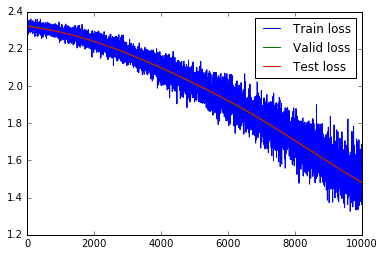

In [6]:
# # Display the learning curve and losses for training, validation, and testing
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

plt.plot(nn.losses['train'], label='Train loss')
plt.plot(nn.losses['valid'], label='Valid loss')
plt.plot(nn.losses['test'], label='Test loss')
plt.legend()
plt.show()

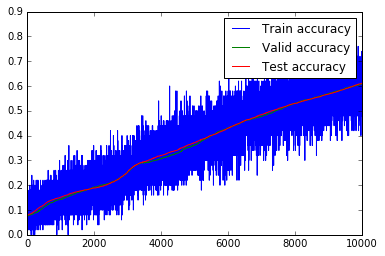

In [7]:
plt.plot(nn.losses['train_acc'], label='Train accuracy')
plt.plot(nn.losses['valid_acc'], label='Valid accuracy')
plt.plot(nn.losses['test_acc'], label='Test accuracy')
plt.legend()
plt.show()